# **Titanic - Machine Learning from Disaster**


# Table of Contents

* [1: Modules](#Modules)
* [2: Preparing Data](#PreparingData)
    * [2.1: Read Data](#ReadData)
    * [2.2: Missed Data Status](#MissedDataStatus)
    * [2.3: Data Labeling](#DataLabeling)
    * [2.3: Data Visualization](#DataVisualization)
    * [2.3: Imputer Design](#ImputerDesign)
    * [2.3: Encoder Design](#EncoderDesign)
    * [2.3: Drop Useless Features](#DropUselessFeatures)
* [3: Dimensionality Reduction](#DimensionalityReduction)
    * [3.1: Sensitivity Analysis](#SensitivityAnalysis)
        * [2.3: Decide on effective features](#DecideonEffectiveFeatures)
    * [2.3: tSNE Algorithm](#tSNEAlgorithm)
    * [2.3: UMAP Algorithm](#UMAPAlgorithm)
    
* [4: Machine Learning Design](#MachineLearning)
    * [3.3: Scaling](#Scaling)
    * [3.3: Cross Validation Prediction](#CrossValidationPrediction)
    * [3.4: Tuning Hyper Parameters](#TuningHyperParameters)
    * [3.5: Pipe Line Design](#Pipeline)
    * [3.5: Prediction](#Prediction)
    


<a class="anchor" id="Modules"></a>
### **Modules** 

In [42]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
import math
from sklearn import svm, ensemble
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
from sklearn.metrics import classification_report
from matplotlib.pyplot import figure
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV


### **Preparing Data** 
<a class="anchor" id="PreparingData"></a>


<a class="anchor" id="ReadData"></a>
#### **Read Data** 

In [63]:
# mdata = pd.read_csv('/kaggle/input/titanic/train.csv')
mdata = pd.read_csv('/kaggle/input/titanic/train.csv')
tdata = pd.read_csv('/kaggle/input/titanic/test.csv')
mdata.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
mdata.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


<a class="anchor" id="MissedDataStatus"></a>
#### **Missed Data Status** 

Text(41.25, 0.5, 'Observation')

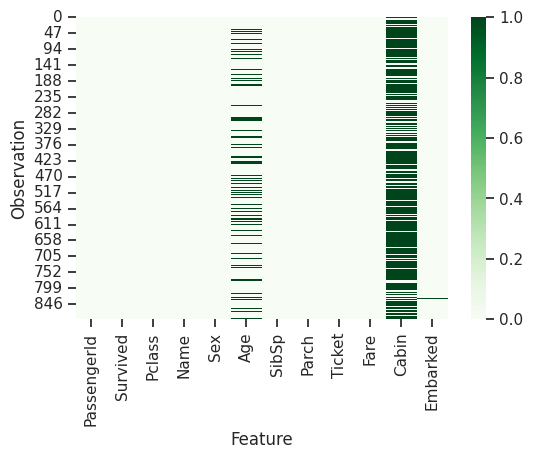

In [66]:
plt.figure(dpi=100)
sns.heatmap(mdata.isnull(), cmap="Greens")
plt.xlabel('Feature')
plt.ylabel('Observation')


<a class="anchor" id="DataLabeling"></a>
#### **Data Labeling**

In [68]:
def data_cleaner(data):
    data["Title"] = data["Name"].apply(lambda x: x[x.find(',') : x.find('.')][1:].strip())
    data["Title"] = data["Title"].apply(lambda x: 'Mr' if x == 'Mr' else x) # Mr
    data["Title"] = data["Title"].apply(lambda x: 'Miss' if x == 'Ms'or x == 'Mme' or x=='Mlle' else x) #Miss
    data["Title"] = data["Title"].apply(lambda x: 'Mrs' if x == 'Mrs' else x) #Mrs
    data["Title"] = data["Title"].apply(lambda x: 'Master' if x == 'Master' else x) #Master
    data["Title"] = data["Title"].apply(lambda x: 'Others' if x != 'Mr' and x != 'Miss' and x!= 'Mrs' and x!= 'Master' else x)

    data["Age_group"] = data["Age"].apply( lambda x: 'KIDs' if math.isnan(x)==False and x<=10 else x)
    data["Age_group"] = data["Age_group"].apply( lambda x: 'TEENs' if (type(x)!=str and math.isnan(x)==False and x<=20 and x >10) else x)
    data["Age_group"] = data["Age_group"].apply( lambda x: 'YOUNGs' if (type(x)!=str and math.isnan(x)==False and x<=40 and x >20) else x)
    data["Age_group"] = data["Age_group"].apply( lambda x: 'OLDs' if (type(x)!=str and math.isnan(x)==False and x >40) else x)
    
    data["FamSize"] = data["SibSp"]+data["Parch"]
    data["FamSizeLabel"] = data["FamSize"].apply( lambda x: 'Small' if int(x)<=2 else 'Large')

    data["FareInter"] = data["Fare"].apply(   
        lambda x: 'LowFare' if x<=7.910400 else ('MidFar' if float(x)>=7.910400 and float(x)<=14.454200 else "HighFare"))
                                  

    return data

data_cleaner(mdata)
data_cleaner(tdata)
mdata.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Age_group,FamSize,FamSizeLabel,FareInter
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,YOUNGs,1,Small,LowFare
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,YOUNGs,1,Small,HighFare
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,YOUNGs,0,Small,MidFar
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,YOUNGs,1,Small,HighFare
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,YOUNGs,0,Small,MidFar


<a class="anchor" id="DataVisualization"></a>
#### **Data Visualization**

In [7]:
xcol = ["Age_group","Title", "Sex","Embarked", "Pclass","FamSizeLabel" ]
huecol = "Survived"
r = 3
c = 2
def mybar(data, xcol, huecol, r, c):
    i = -1
    sns.set_theme(style="ticks")
    f, ax = plt.subplots(r,c,figsize=(18, 7))
    sns.despine(f)
    for col in xcol:
        i+=1
        y = lambda y: int(0) if y<3 else int(1)
        x = lambda x: x if x<3 else int(x-3)
        sns.histplot( data, x=col, hue=huecol, multiple="stack", palette="light:m_r",
            edgecolor=".3", linewidth=.5, log_scale=False,ax = ax[x(i), y(i)])

<a class="anchor" id="ImputerDesign"></a>
#### **Imputer Design**

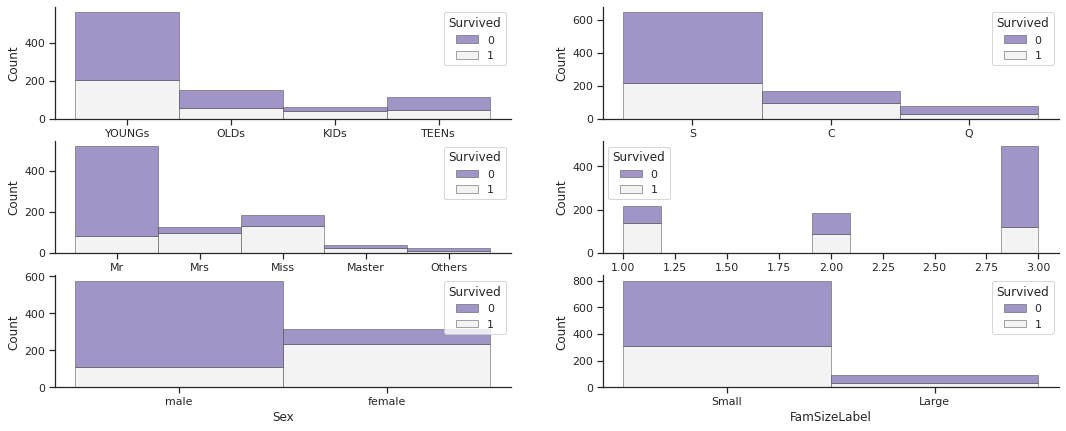

In [69]:
# # Imputers

Imputer = SimpleImputer(strategy= 'most_frequent', missing_values=np.nan)
Imputer.fit(mdata[['Age_group']])
mdata[['Age_group']] = Imputer.transform(mdata[["Age_group"]])
Imputer.fit(mdata[['Embarked']])
mdata[['Embarked']] = Imputer.transform(mdata[["Embarked"]])
#-----
Imputer.fit(tdata[['Age_group']])
tdata[['Age_group']] = Imputer.transform(tdata[["Age_group"]])
Imputer.fit(tdata[['Embarked']])
tdata[['Embarked']] = Imputer.transform(tdata[["Embarked"]])
mybar(mdata, xcol, huecol, r, c)

<a class="anchor" id="EncoderDesign"></a>
#### **Encoder Design**

In [73]:
# Encoding
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')

def titanic_encoder(data):
    enc.fit(data[["Embarked"]])
    data[["S","Q","C"]] = \
        pd.DataFrame(enc.transform(data[["Embarked"]]).toarray())
    #----
    enc.fit(data[["Sex"]])
    data[["F","M"]] = \
        pd.DataFrame(enc.transform(data[["Sex"]]).toarray())
    #----
    #----
    enc.fit(data[["Age_group"]])
    data[["Age1","Age2","Age3","Age4"]] = \
        pd.DataFrame(enc.transform(data[["Age_group"]]).toarray())
    #----
    enc.fit(mdata[["FamSizeLabel"]])
    data[["Small","Large"]] = \
        pd.DataFrame(enc.transform(data[["FamSizeLabel"]]).toarray())
    #----
    enc.fit(mdata[["Pclass"]])
    data[["C1","C2","C3"]] = \
        pd.DataFrame(enc.transform(data[["Pclass"]]).toarray())
    #----
    enc.fit(mdata[["FareInter"]])
    data[["F1","F2","F3"]] = \
        pd.DataFrame(enc.transform(data[["FareInter"]]).toarray())
    return data
titanic_encoder(mdata)
titanic_encoder(tdata)
mdata.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Age3,Age4,Small,Large,C1,C2,C3,F1,F2,F3
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


<a class="anchor" id="DropUselessFeatures"></a>
#### **Drop Useless Features**
There are some useless columns like "Name", "Cabin" that their information does not contribute in making a model. Moreover those columns whose data are encoded to binaries are also removed. Because I am going to work with the binary data. 

In [79]:

col = ["Age","PassengerId","Sex","Name","Cabin","Ticket","Embarked","Title","FamSize","SibSp","Parch","Age_group","Pclass","FamSizeLabel",'Fare',"FareInter"]
mdata_drp = mdata.drop(col,axis = 1)
tdata_drp = tdata.drop(col,axis = 1)

<a class="anchor" id="DimensionalityReduction"></a>
## **Dimensionality Reduction**

<a class="anchor" id="SensitivityAnalysis"></a>
#### **Sensitivity Analysis**

Text(0.0, 1.0, 'A')

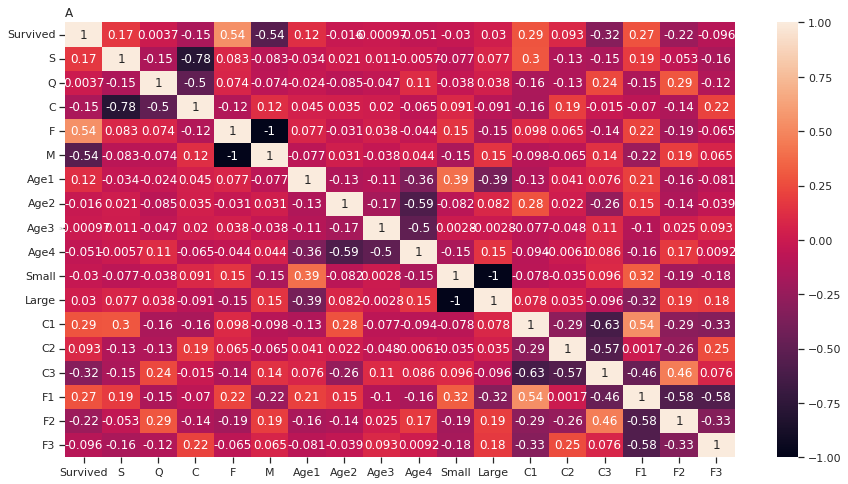

In [11]:
myheatmap=plt.figure(figsize=(15,8))
sns.heatmap(mdata_drp.corr(),annot=True)
plt.title("A",loc='left')

<a class="anchor" id="DecideonEffectiveFeatures"></a>
#### **Decide on Effective Features**

In [76]:
var_col =  ["S","C","F","M","Age1","Age2","Age4","Small","Large","C1","C2","C3",'F1',"F2","F3"]
fit_col = "Survived"
mdata_drp[var_col].head()


,S,C,F,M,Age1,Age2,Age4,Small,Large,C1,C2,C3,F1,F2,F3
0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


<a class="anchor" id="UMAPAlgorithm"></a>
#### **UMAP Algorithm**
Uniform Manifold Approximation and Projection (UMAP) is a dimension reduction technique that can be used for visualisation similarly to t-SNE, but also for general non-linear dimension reduction.

In [ ]:
import umap
trans = umap.UMAP(n_neighbors=50, random_state=3, min_dist=0.3,
                      metric='correlation').fit(mdata_drp[var_col])
plt.figure(figsize = (10,5))
plt.scatter(trans.embedding_[:, 0], trans.embedding_[:, 1], s= 10, c=[sns.color_palette()[x] for x in mdata_drp[fit_col]])
plt.xlabel("Dim1")
plt.ylabel("Dim2")


<a class="anchor" id="MachineLearning"></a>
## **Machine Learning**

<a class="anchor" id="Scaling"></a>
#### **Split Data**

In [92]:
y = mdata_drp[fit_col].values
y=np.reshape(y,(len(y),))
x_train, x_test, y_train, y_test = train_test_split(mdata_drp[var_col], y,
                                                    train_size=0.85,
                                                    random_state=0)

<a class="anchor" id="CrossValidationPrediction"></a>
#### **Cross Validation Prediction**

In [93]:
estimators = [svm.SVC(),
              ensemble.RandomForestClassifier(),
              KNeighborsClassifier(), SGDClassifier()]

def run_compare(estis,x,y,cv=3):
    for esti in estis:
        y_pred = cross_val_predict(esti,x,y,cv=cv)
        print(f"\nClassification Report for {esti}:")
        print("Accuracy= ", accuracy_score(y_pred, y))
        print(confusion_matrix(y_pred, y))
        print(classification_report(y_pred,y))
        
run_compare(estimators,mdata_drp[var_col],y, cv=3)


Classification Report for SVC():
Accuracy=  0.8226711560044894
[[502 111]
 [ 47 231]]
              precision    recall  f1-score   support

           0       0.91      0.82      0.86       613
           1       0.68      0.83      0.75       278

    accuracy                           0.82       891
   macro avg       0.79      0.82      0.80       891
weighted avg       0.84      0.82      0.83       891


Classification Report for RandomForestClassifier():
Accuracy=  0.8002244668911336
[[486 115]
 [ 63 227]]
              precision    recall  f1-score   support

           0       0.89      0.81      0.85       601
           1       0.66      0.78      0.72       290

    accuracy                           0.80       891
   macro avg       0.77      0.80      0.78       891
weighted avg       0.81      0.80      0.80       891


Classification Report for KNeighborsClassifier():
Accuracy=  0.8069584736251403
[[500 123]
 [ 49 219]]
              precision    recall  f1-score   sup

<a class="anchor" id="TuningHyperParameters"></a>
#### **Tuning Hyper Parameters**

In [94]:
# Parameters of random forest classifier
n_estimators = [10,50,100,150,200]
max_depth = [5, 10, 50, 100, 200]
min_samples_split = [2, 4, 6]
max_features = ["sqrt", "log2"]
bootstrap = [True, False]

distributions = {
    "n_estimators": n_estimators,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "max_features": max_features,
    "bootstrap": bootstrap
}

In [95]:
iestimator = RandomizedSearchCV(
    ensemble.RandomForestClassifier(),
    param_distributions=distributions,
    n_iter=30,
    cv=3,
    n_jobs=4
)

iestimator_dict = iestimator.fit(x_train,y_train)

In [96]:
best_config= iestimator_dict.best_estimator_
best_y_pred = cross_val_predict(best_config, x_train,y_train, cv=3)
print("Accuracy= ", accuracy_score(best_y_pred, y_train))
print(confusion_matrix(best_y_pred, y_train))
print(classification_report(best_y_pred,y_train))

Accuracy=  0.8071334214002642
[[423  99]
 [ 47 188]]
              precision    recall  f1-score   support

           0       0.90      0.81      0.85       522
           1       0.66      0.80      0.72       235

    accuracy                           0.81       757
   macro avg       0.78      0.81      0.79       757
weighted avg       0.82      0.81      0.81       757



In [97]:
best_config= iestimator_dict.best_estimator_
best_y_pred = cross_val_predict(best_config, x_test,y_test, cv=3)
print("Accuracy= ", accuracy_score(best_y_pred, y_test))
print(confusion_matrix(best_y_pred, y_test))
print(classification_report(best_y_pred,y_test))

Accuracy=  0.8134328358208955
[[66 12]
 [13 43]]
              precision    recall  f1-score   support

           0       0.84      0.85      0.84        78
           1       0.78      0.77      0.77        56

    accuracy                           0.81       134
   macro avg       0.81      0.81      0.81       134
weighted avg       0.81      0.81      0.81       134



In [127]:
tdata_final = pd.DataFrame([tdata['PassengerId'],best_config.predict(tdata_drp[var_col])],index = ['PassengerId','Survived']).T
tdata_final.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


<a class="anchor" id="Pipeline"></a>
#### **Pipe Line Design**

<a class="anchor" id="Prediction"></a>
#### **Prediction**